In [45]:
!pip install pmdarima

In [27]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox

In [46]:
data = pd.read_csv('train.csv')
data.sample(11)

,Timestamps,NormalizedSteps
99,2024-07-24 11:41:45.415360,0.615251
136,2024-07-24 12:18:45.415360,0.580691
8,2024-07-24 10:10:45.415360,0.659847
13,2024-07-24 10:15:45.415360,0.659847
75,2024-07-24 11:17:45.415360,0.814641
137,2024-07-24 12:19:45.415360,0.580691
170,2024-07-24 12:52:45.415360,0.383017
82,2024-07-24 11:24:45.415360,0.746664
149,2024-07-24 12:31:45.415360,0.568292
124,2024-07-24 12:06:45.415360,0.580691


In [64]:
data.isnull().sum()

,0
Timestamps,0
NormalizedSteps,0


In [48]:
data.describe()

,NormalizedSteps
count,180.000000
mean,0.658522
std,0.164336
min,0.244525
25%,0.580691
50%,0.659847
75%,0.737869
max,1.000000


In [49]:
figure = px.line(data,x="Timestamps",y="NormalizedSteps",title='Conversion Rate over the time')
figure.show()

<Figure size 640x480 with 0 Axes>

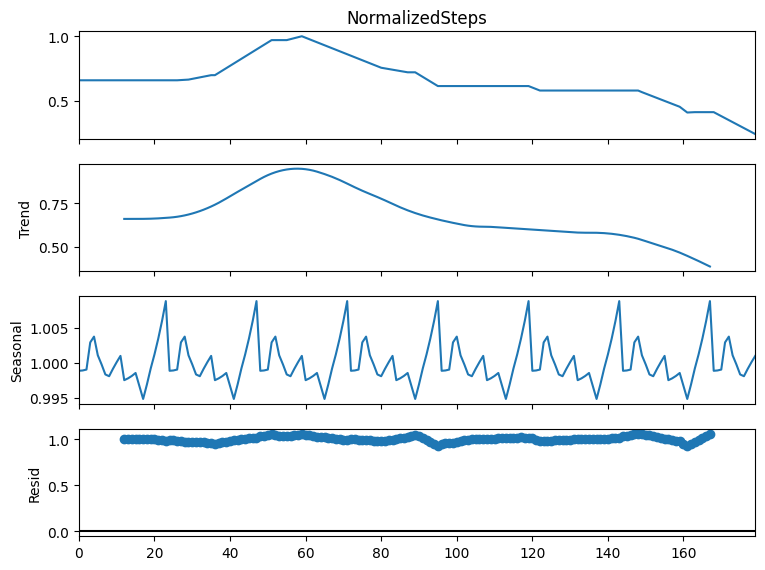

In [65]:
# Check for minimum value and shift the data
min_value = data['NormalizedSteps'].min()
if min_value <= 0:
    data['NormalizedSteps'] = data['NormalizedSteps'] - min_value + 1

# Decompose the time series using the multiplicative model
result = seasonal_decompose(data['NormalizedSteps'], model='multiplicative', period=24)

# Create a figure and plot the decomposition
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
plt.show()


Determine p d q Values
p - Auto Regression(Lag observed)
d - Integrated part ( degree of first difference involved)
q - Moving Average (order of the moving average)

In [50]:
# To determine p d q we can use -> pmdarima library
model = auto_arima(data['NormalizedSteps'], seasonal=True, m=24,suppress_warnings=True)
print(model.order)

# Here 'm' depends on the frequency of the data
# For timestamps m = 24
# For weekly pattern m = 24*7 = 168
# For daily m = 365
# for weekly m = 52

(0, 2, 0)


p = 0
d = 2
q = 0

Now let's train the model using SARIMA

In [52]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore',ValueWarning)

p,d,q = 0,2,0
model = SARIMAX(data['NormalizedSteps'],order=(p,d,q), seasonal_order=(p,d,q,24))

result = model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    NormalizedSteps   No. Observations:                  180
Model:             SARIMAX(0, 2, 0)x(0, 2, 0, 24)   Log Likelihood                 406.789
Date:                            Thu, 01 Aug 2024   AIC                           -811.578
Time:                                    15:48:40   BIC                           -808.710
Sample:                                         0   HQIC                          -810.412
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   6.69e-06     16.735      0.000    9.88e-05       0.000
Ljung-Box (L1) (Q):                

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [53]:
predictions = result.predict(len(data),len(data)+90)
print(predictions)

180    0.229137
181    0.213749
182    0.198362
183    0.182974
184    0.145847
         ...   
266    0.645813
267    0.640959
268    0.636105
269    0.680850
270    0.721189
Name: predicted_mean, Length: 91, dtype: float64


Show the prediction values and training data in the graph

In [54]:
fig = go.Figure()

#Training data line plot
fig.add_trace(go.Scatter(x=data.index,y=data['NormalizedSteps'],mode = 'lines',name = 'Training Data',line=dict(color='blue')))

#Prediction line plot

fig.add_trace(go.Scatter(x=predictions.index,y=predictions,mode='lines',name='Predictions',line=dict(color='red')))

fig.update_layout(
    title="Training Data VS Predictions",
    xaxis_title = "Timestamps",
    yaxis_title = "NormalizedSteps",
    legend_title = "Timestamps",
    width = 600,
    height = 600
)

pio.show(fig)

In [55]:
val = pd.read_csv('val.csv')
val

,Timestamps,NormalizedSteps
0,2024-07-24 13:02:45.415360,0.243223
1,2024-07-24 13:03:45.415360,0.241921
2,2024-07-24 13:04:45.415360,0.240619
3,2024-07-24 13:05:45.415360,0.239316
4,2024-07-24 13:06:45.415360,0.238014
5,2024-07-24 13:07:45.415360,0.236712
6,2024-07-24 13:08:45.415360,0.235409
7,2024-07-24 13:09:45.415360,0.234107
8,2024-07-24 13:10:45.415360,0.232805
9,2024-07-24 13:11:45.415360,0.231502


In [56]:
import plotly.graph_objects as go
import plotly.io as pio

fig = go.Figure()

# Training data line plot
fig.add_trace(go.Scatter(x=data.index, y=data['NormalizedSteps'], mode='lines', name='Training Data', line=dict(color='blue')))

# Validation data line plot
fig.add_trace(go.Scatter(x=val['Timestamps'], y=val['NormalizedSteps'], mode='lines', name='Validation Data', line=dict(color='green')))

fig.update_layout(
    title="Training Data VS Validation Data",
    xaxis_title="Timestamps",
    yaxis_title="Normalized Steps",
    legend_title="Data Type",
    width=600,
    height=600
)

pio.show(fig)


## Let's validate both train and val dataset

In [57]:
forecast_df = pd.read_csv('train.csv',parse_dates=['Timestamps'])
validation_df = pd.read_csv('val.csv',parse_dates=['Timestamps'])
validation_df.rename(columns={'Normalized Steps':'actual_value'},inplace=True)
validation_df.set_index('Timestamps',inplace=True)

print("Validation Dataframe columns:",validation_df.columns)
validation_df.head()

Validation Dataframe columns: Index(['NormalizedSteps'], dtype='object')


,NormalizedSteps
Timestamps,
2024-07-24 13:02:45.415360,0.243223
2024-07-24 13:03:45.415360,0.241921
2024-07-24 13:04:45.415360,0.240619
2024-07-24 13:05:45.415360,0.239316
2024-07-24 13:06:45.415360,0.238014


In [58]:
forecast = result.get_forecast(steps=len(validation_df))
forecasted_values = forecast.predicted_mean

In [59]:
#Create DataFrame for forecasted values
forecast_df = pd.DataFrame({
    'Timestamps':validation_df.index,
    'forecasted_values': forecasted_values
})
forecast_df.set_index('Timestamps',inplace=True)
print("Forecast DataFrame columns:",forecast_df.columns)
forecast_df.head()
# Ensure the forecasted values are in flost format
# forecast_df['forecasted_values'] = forecast_df['forecasted_values'].astype(float)

Forecast DataFrame columns: Index(['forecasted_values'], dtype='object')


,forecasted_values
Timestamps,
2024-07-24 13:02:45.415360,0.229137
2024-07-24 13:03:45.415360,0.213749
2024-07-24 13:04:45.415360,0.198362
2024-07-24 13:05:45.415360,0.182974
2024-07-24 13:06:45.415360,0.145847


In [60]:
#Align the forecast and validation data based on the timestamps index
merged_df = forecast_df.join(validation_df[['NormalizedSteps']],how='inner')
print("Merge DataFrame:",merged_df.head())

Merge DataFrame:                             forecasted_values  NormalizedSteps
Timestamps                                                    
2024-07-24 13:02:45.415360           0.229137         0.243223
2024-07-24 13:03:45.415360           0.213749         0.241921
2024-07-24 13:04:45.415360           0.198362         0.240619
2024-07-24 13:05:45.415360           0.182974         0.239316
2024-07-24 13:06:45.415360           0.145847         0.238014


In [61]:
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(merged_df['NormalizedSteps'], merged_df['forecasted_values'])
mse = mean_squared_error(merged_df['NormalizedSteps'], merged_df['forecasted_values'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((merged_df['NormalizedSteps'] - merged_df['forecasted_values']) / merged_df['NormalizedSteps'])) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

MAE: 0.15306964965261402
MSE: 0.027629045242643726
RMSE: 0.16621987017996293
MAPE: inf%


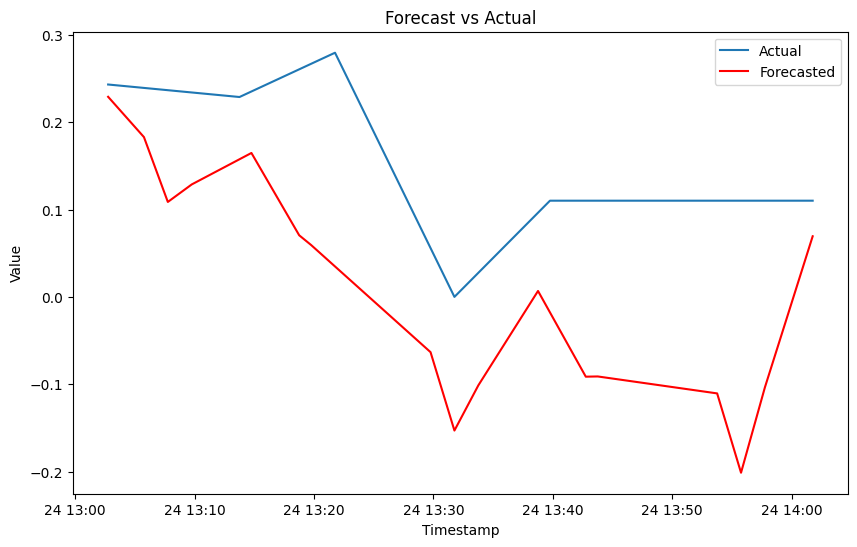

In [62]:
# Plotting
plt.figure(figsize=(10,6))
plt.plot(merged_df.index, merged_df['NormalizedSteps'],label='Actual')
plt.plot(merged_df.index, merged_df['forecasted_values'],label='Forecasted',color='red')
plt.legend()
plt.title('Forecast vs Actual')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()